In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm
from glob import glob
from scipy.stats import norm
from scipy.special import softmax
from datetime import datetime, time

from model import baseline
from model.helpers import square_exponential_kernel, normalize_last_dim
from plot import plot
from data.data_path import data_path

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

# from model.ball_base_model import *

from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from scripts.compute_transition_matrices import plot_transition_matrix

In [4]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [5]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# Load data
step_events = load_data(user)
print("n_days raw", len(step_events))
step_events = [i for i in step_events if len(i)]
n_days = len(step_events)
print("n_days after filtering empty days", len(step_events))

n_days raw 18
n_days after filtering empty days 17


In [6]:
from scipy.special import logit
from scipy.special import expit as sigmoid

In [7]:
# jitter = np.finfo(np.float64).tiny

# Define the range of number of components to try
n_components_range = range(1, 11)
cmp_score = np.zeros((n_days, len(list(n_components_range))))

for day in range(n_days):
    print(f"Day {day}", len(step_events[day]), "steps")
    X = logit(np.asarray(step_events[day]).reshape(-1, 1))
    # List to hold the BIC for each number of components
    
    # Fit a Gaussian Mixture Model for each number of components
    for i, n_components in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        cmp_score[day, i] = gmm.aic(X)

Day 0 1465 steps
Day 1 3112 steps
Day 2 808 steps
Day 3 1584 steps
Day 4 2247 steps
Day 5 7052 steps
Day 6 7080 steps
Day 7 2218 steps
Day 8 7013 steps
Day 9 7675 steps
Day 10 2820 steps
Day 11 3012 steps
Day 12 7011 steps
Day 13 64 steps
Day 14 7179 steps
Day 15 2561 steps
Day 16 3717 steps


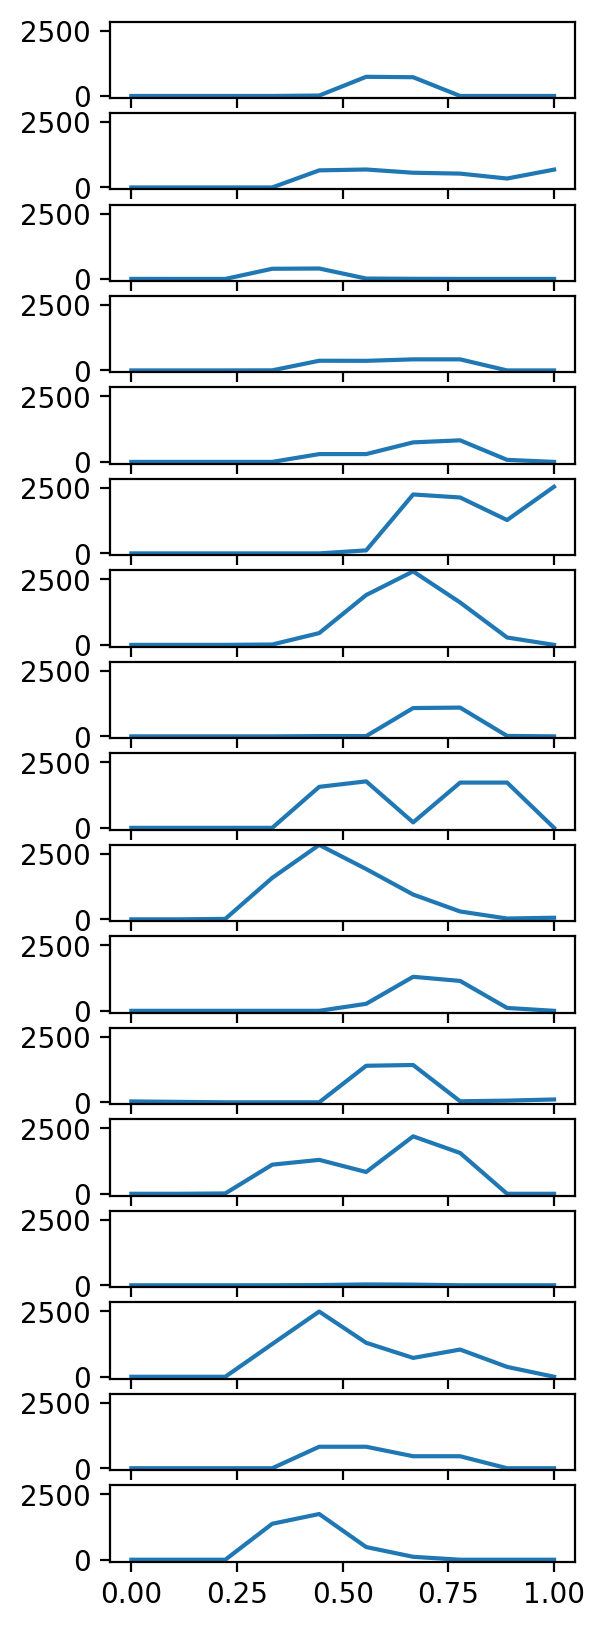

In [8]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [9]:
len(list(n_components_range))

10

n days 17


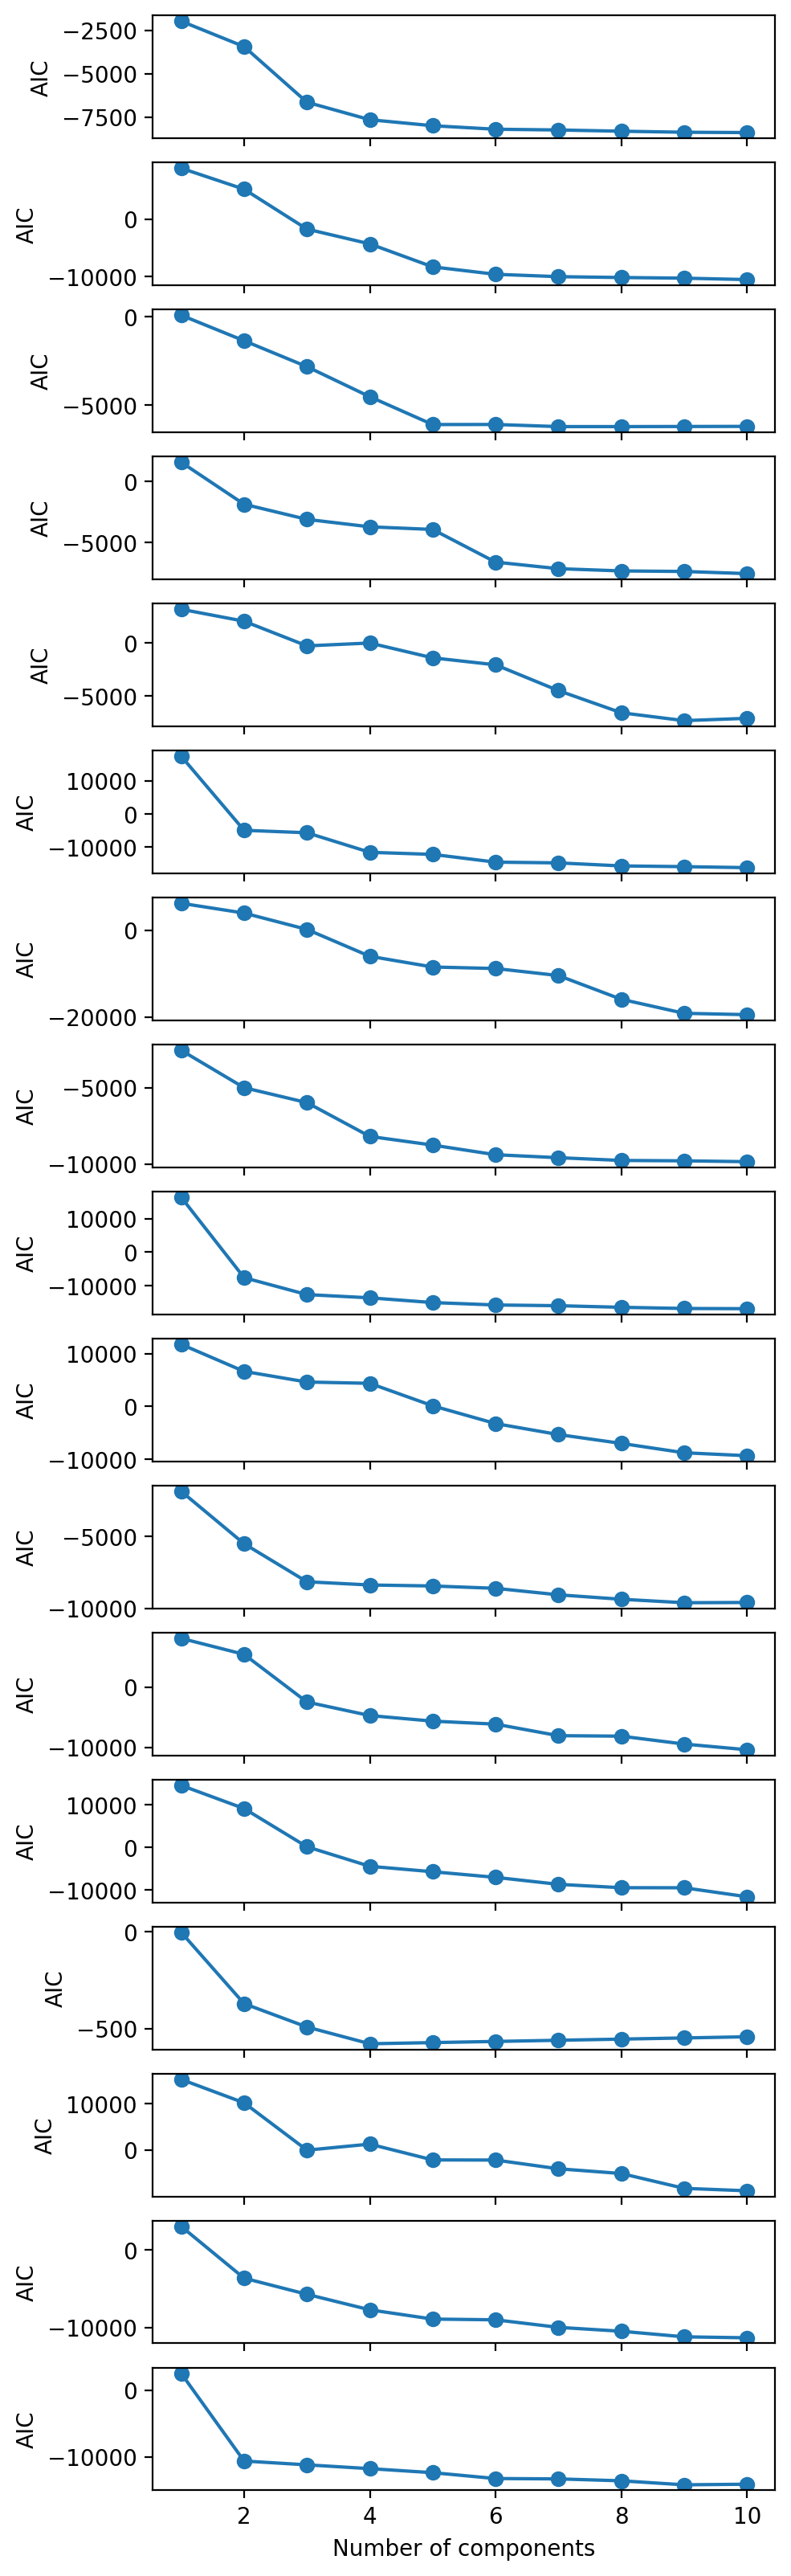

In [10]:
fig, axes = plt.subplots(nrows=n_days, figsize=(5, 20), sharex=True)
print("n days", n_days)
for day in range(n_days):
    ax = axes[day]
    ax.plot(n_components_range, cmp_score[day], marker='o')
    if day == n_days-1:(
        ax.set_xlabel('Number of components'))
    ax.set_ylabel('AIC')

In [11]:
param = np.zeros((n_days, 3)) # mu, sigma, n

# Define the range of number of components to try
n_components_range = range(1, 11)
cmp_score = np.zeros((n_days, len(list(n_components_range))))

max_n = max([len(step_events[day]) for day in range(n_days)])

for day in range(n_days):
    X = np.asarray(step_events[day])
    param[day] = logit(X.mean()), np.log(X.std()), np.exp(X.size/max_n)

In [12]:
gmm = GaussianMixture(n_components=1)
gmm.fit(param)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

Means: [[ 0.45103159 -2.51574731  1.76193222]]
Covariances: [[[0.16647998 0.03108194 0.03242622]
  [0.03108194 0.37595569 0.23042733]
  [0.03242622 0.23042733 0.35684444]]]


In [13]:
n_samples = 5
samples, _ = gmm.sample(n_samples)

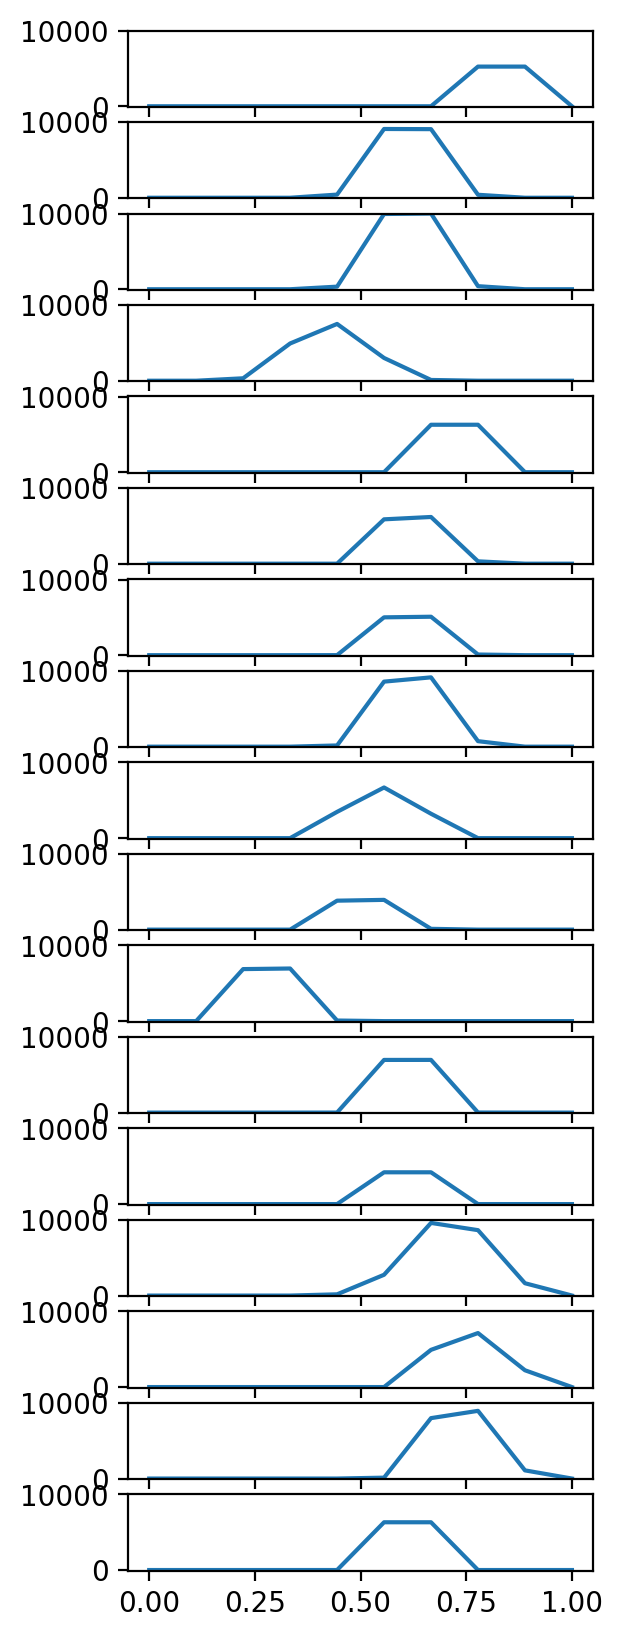

In [14]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    samples, _ = gmm.sample(1)
    smp = samples[0]
    mu = smp[0]
    sigma = np.exp(smp[1])
    n = smp[2]*max_n
    
    draws = np.random.normal(mu, sigma, size=int(n))
    
    step_events_day = sigmoid(draws)
    
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [156]:
# Define the range of number of components to try
n_components_range = range(1, 5)
n_model_types = len(list(n_components_range))

goodness_of_fit = np.zeros((n_days, n_model_types))
params = []  
for n_comp in n_components_range:
    if n_comp == 1:
        # for each model: per day, logit(mean), log1p(var), n
        params.append(np.zeros((n_days, 3)))
    else:
        # for each model: per day, logit(means), log1p(var), logit(coeff)
        params.append(np.zeros((n_days, n_comp*3+1)))

max_n = max([len(step_events[day]) for day in range(n_days)])

cmp_score = np.zeros((n_days, n_model_types))

# 1. Fit 1st level GMMs with different number of components for each day
for day in range(n_days):
    X = np.asarray(step_events[day]).reshape(-1, 1)
    for model, n_components in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        cmp_score[day, model] = gmm.bic(X)
        
        transformed_means = logit(gmm.means_).flatten()
        transformed_vars = np.log1p(gmm.covariances_).flatten()
        transformed_weights = logit(gmm.weights_).flatten()
        transformed_n = np.atleast_1d(np.log1p(X.size / max_n))
        
        if n_components == 1:
            features = [transformed_means, transformed_vars, transformed_n]

        else:
            features = [transformed_means, transformed_vars, transformed_weights, transformed_n]
        params[model][day] = np.concatenate(features)

# 2. Fit a 2nd level GMM per type of model
second_level_gmm = [GaussianMixture(n_components=1).fit(params[model]) for model in range(n_model_types)]

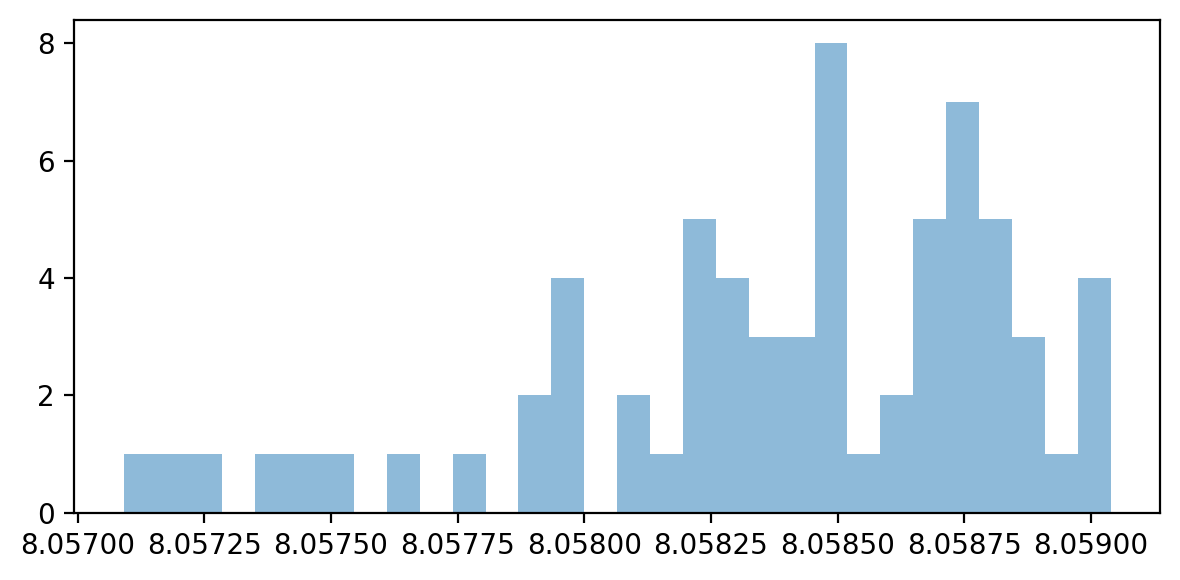

In [157]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(np.log(np.sqrt(1e7+cmp_score.flatten())), bins=30, color="C0", alpha=0.5)
plt.tight_layout()

Lambda parameter:  0.27013598727791976


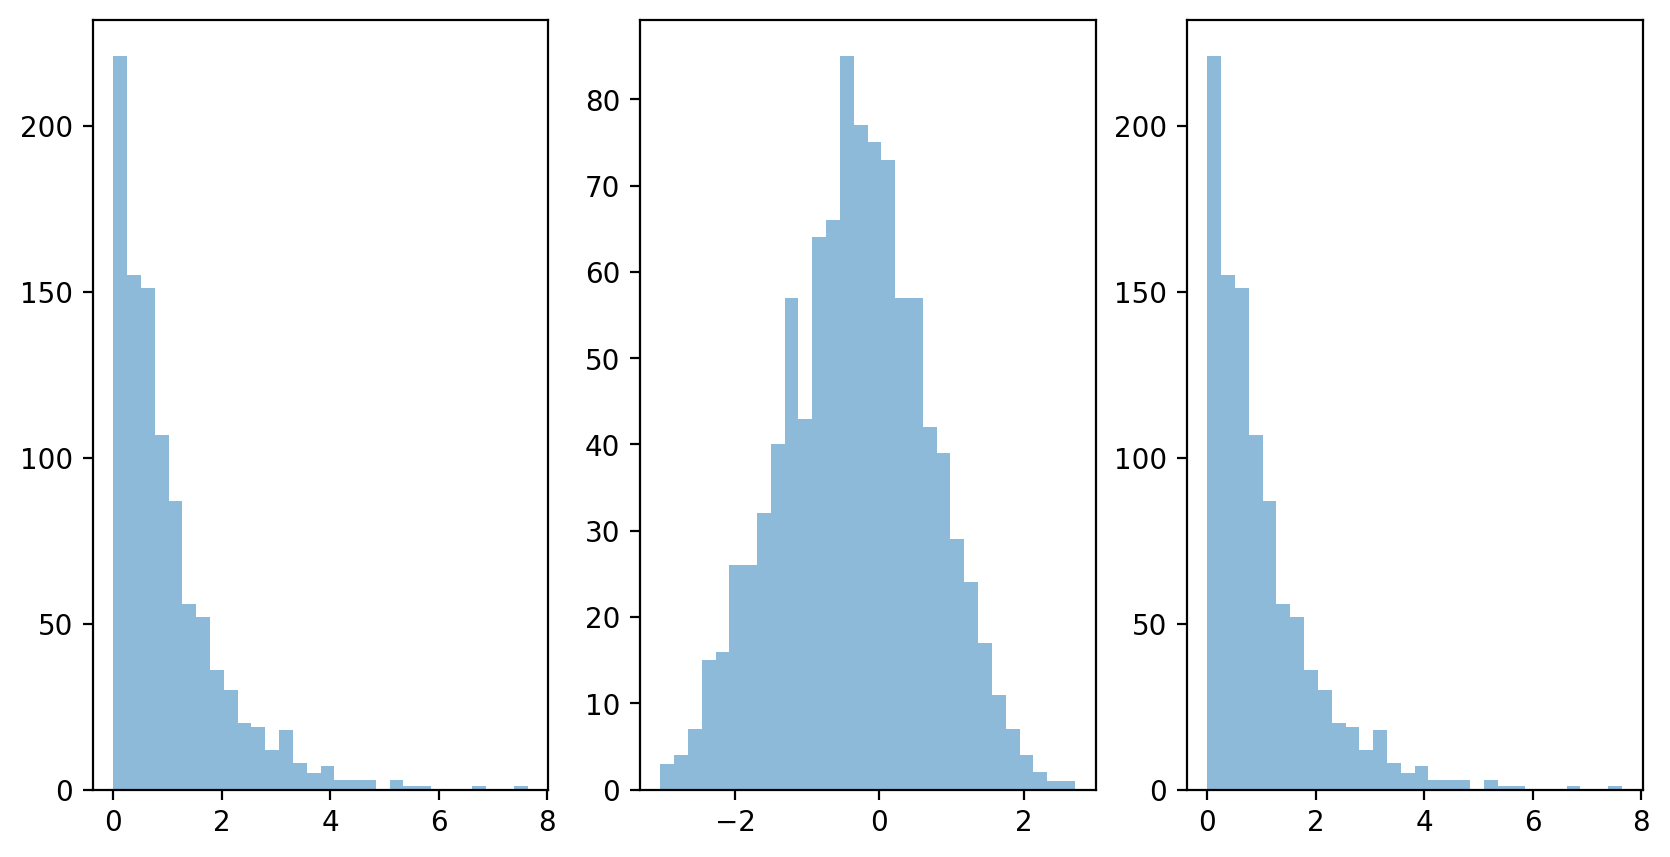

In [158]:
import numpy as np
from scipy import stats
from scipy.special import inv_boxcox

# Assuming you have a 1-d numpy array 'data' with your values
data = np.random.exponential(scale=1.0, size=1000)
# data = np.random.gamma(1.0, 2.0, 1000)

# Apply Box-Cox transformation
transformed_data, lambda_param = stats.boxcox(data)

print("Lambda parameter: ", lambda_param)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].hist(data, bins=30, color="C0", alpha=0.5)
ax[1].hist(transformed_data, bins=30, color="C0", alpha=0.5)
ax[2].hist(inv_boxcox(transformed_data, lambda_param), bins=30, color="C0", alpha=0.5);

Lambda parameter:  44.81906106571101


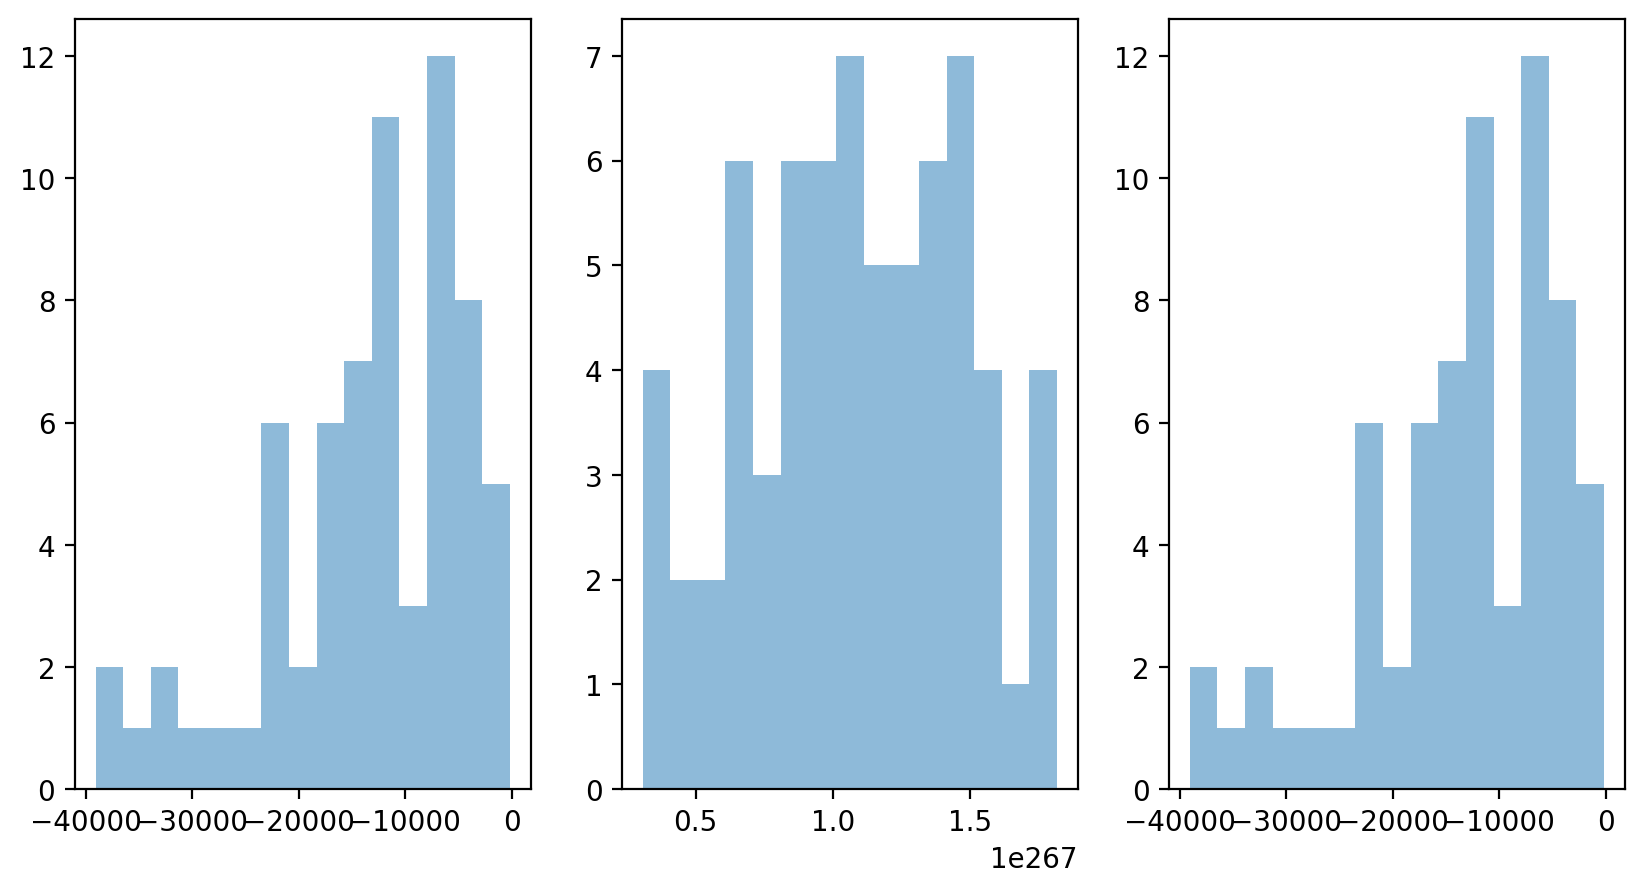

In [159]:
import numpy as np
from scipy import stats
from scipy.special import inv_boxcox

# Assuming you have a 1-d numpy array 'data' with your values
# data = np.random.exponential(scale=1.0, size=1000)
# data = np.random.gamma(1.0, 2.0, 1000)
data = cmp_score.flatten()

# Apply Box-Cox transformation
transformed_data, lambda_param = stats.boxcox(data+1e6)

print("Lambda parameter: ", lambda_param)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].hist(data, bins=15, color="C0", alpha=0.5)
ax[1].hist(transformed_data, bins=15, color="C0", alpha=0.5)
ax[2].hist(inv_boxcox(transformed_data, lambda_param)-1e6, bins=15, color="C0", alpha=0.5);

In [164]:
from sklearn.preprocessing import MinMaxScaler

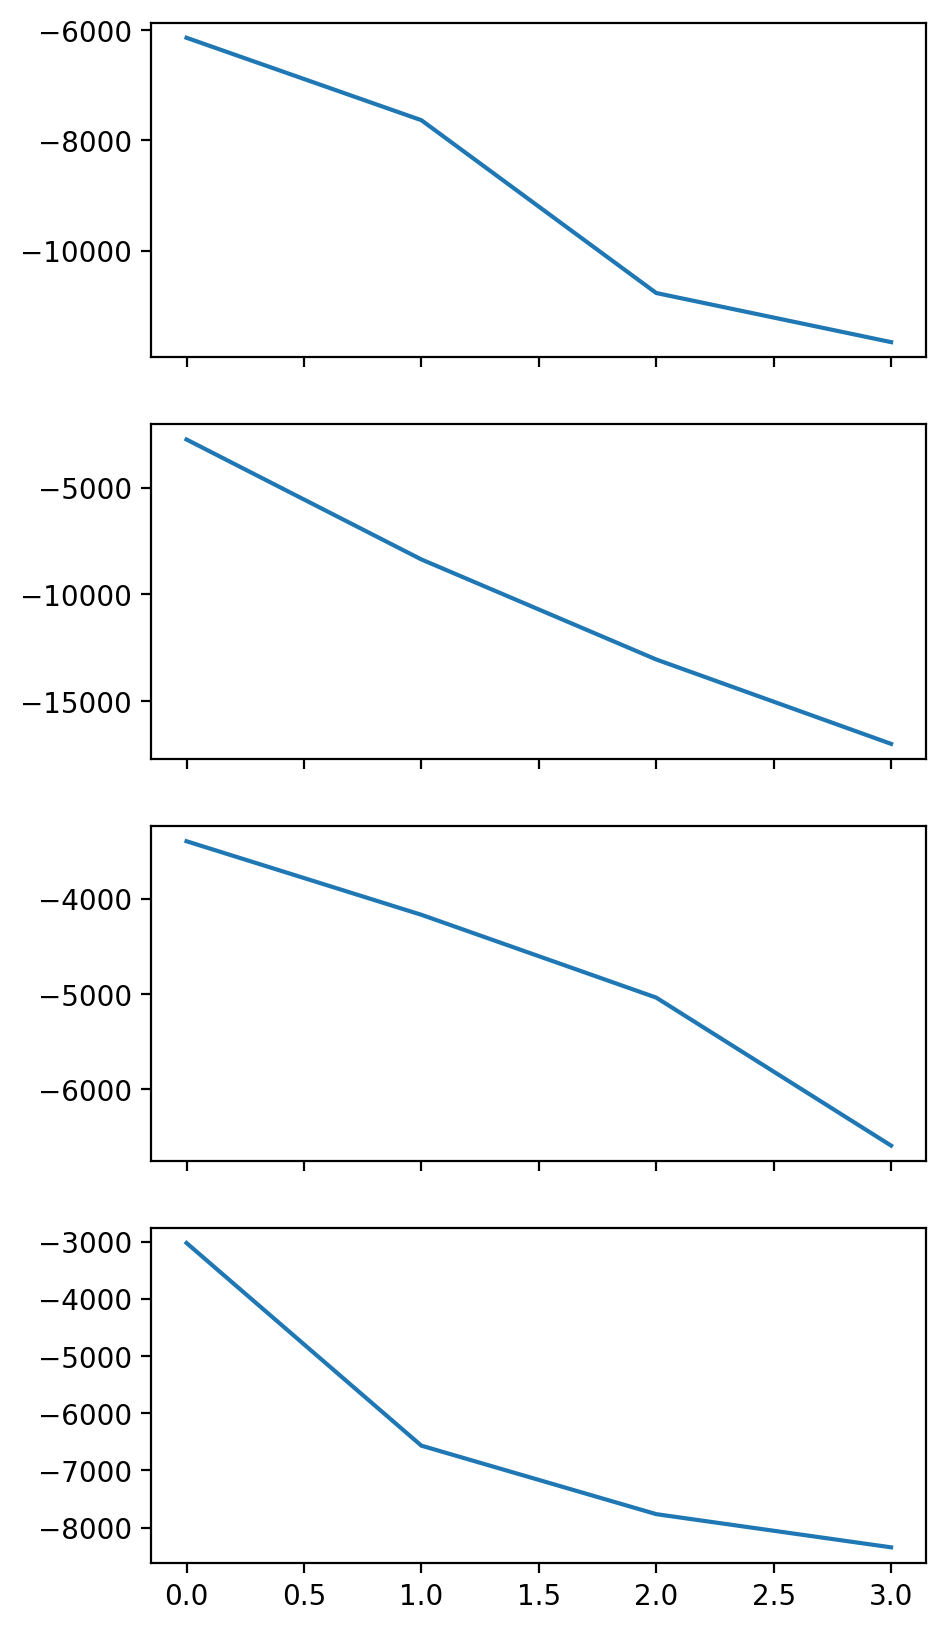

In [195]:
fig, axes = plt.subplots(nrows=n_model_types, figsize=(5, 10), sharex=True)
for day in range(cmp_score.shape[1]):
    ax = axes[day]
    ax.plot(cmp_score[day])
    

In [212]:
org_shape = cmp_score.shape
flat_cmp_score = cmp_score.flatten()
score_scaler = MinMaxScaler(feature_range=(100, 1000))
scaled_scores = score_scaler.fit_transform(flat_cmp_score.reshape(-1, 1)).flatten()
transformed_scores, lambda_param = stats.boxcox(scaled_scores)
transformed_scores = transformed_scores.reshape(org_shape)

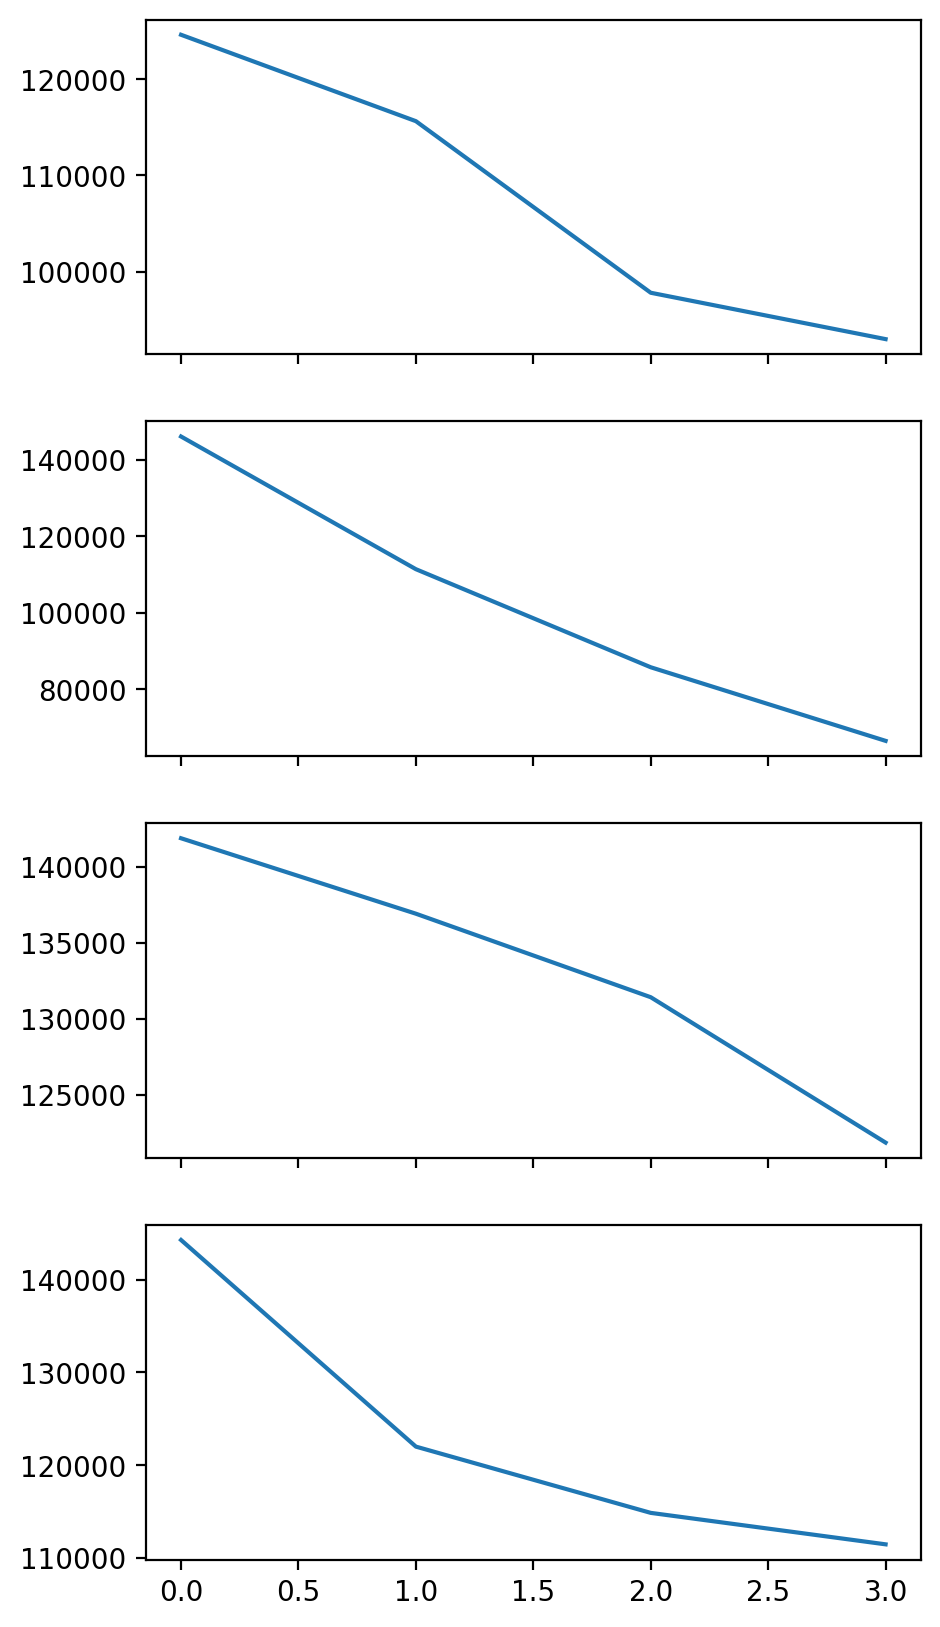

In [213]:
fig, axes = plt.subplots(nrows=n_model_types, figsize=(5, 10), sharex=True)
for day in range(cmp_score.shape[1]):
    ax = axes[day]
    ax.plot(transformed_scores[day])

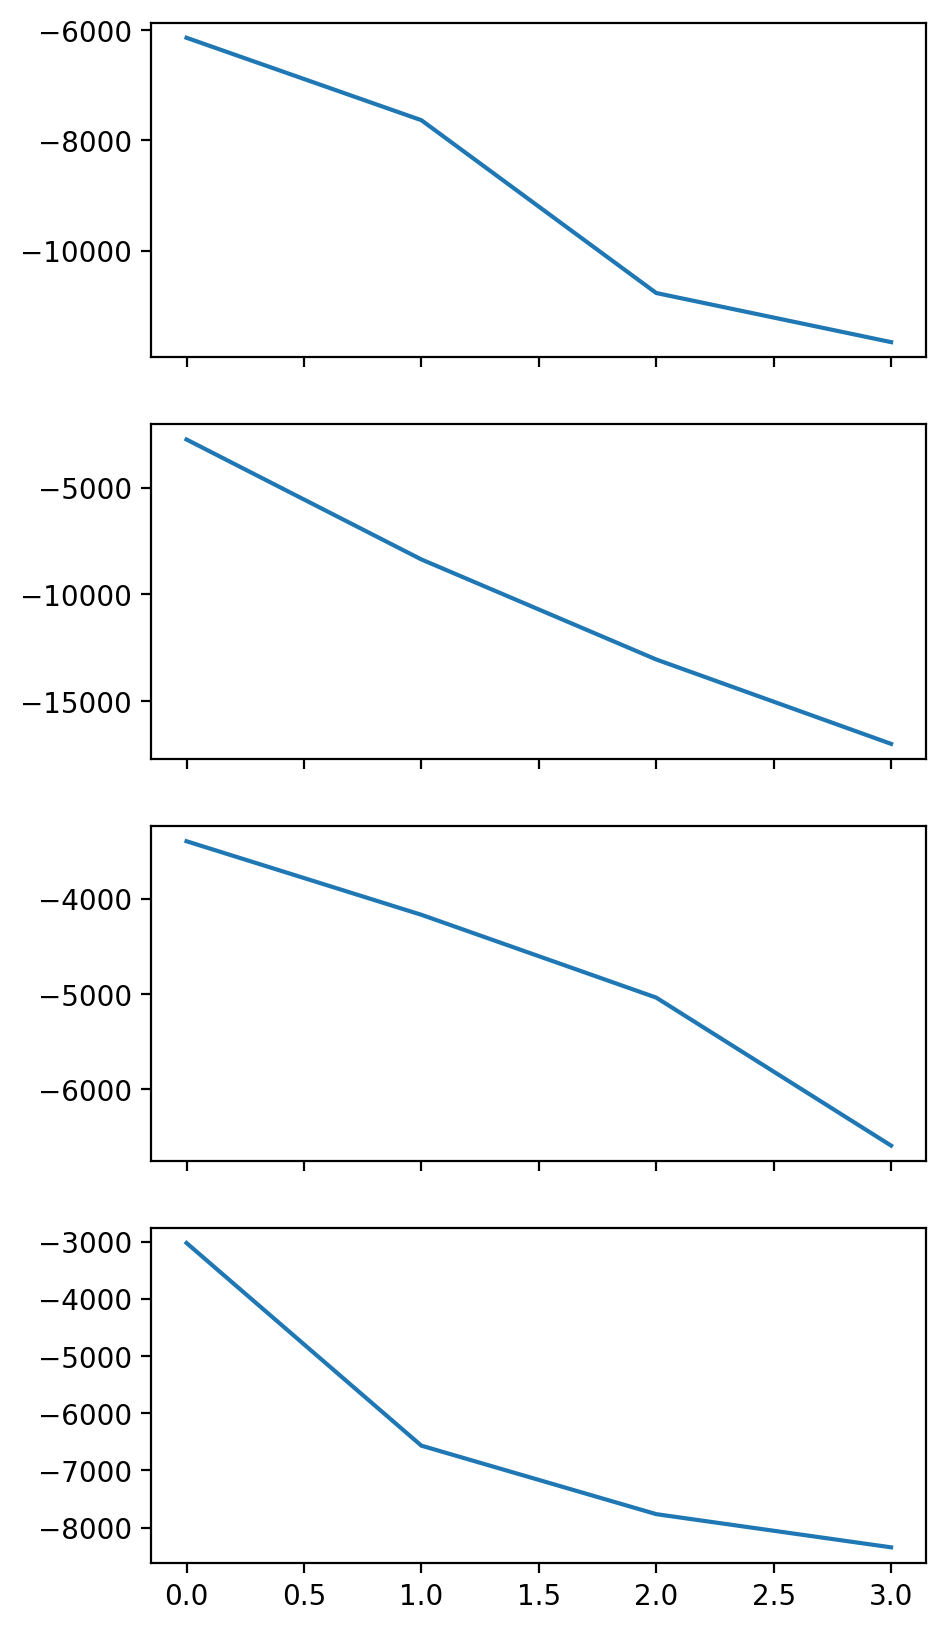

In [214]:
untransformed_scores_ = inv_boxcox(transformed_scores.flatten().reshape(-1, 1), lambda_param)
untransformed_scores = score_scaler.inverse_transform(untransformed_scores_).reshape((-1, n_model_types))

fig, axes = plt.subplots(nrows=n_model_types, figsize=(5, 10), sharex=True)
for day in range(cmp_score.shape[1]):
    ax = axes[day]
    ax.plot(untransformed_scores[day])

1531.8607190496891
1547.3650252329471
1393.5902435974153
0


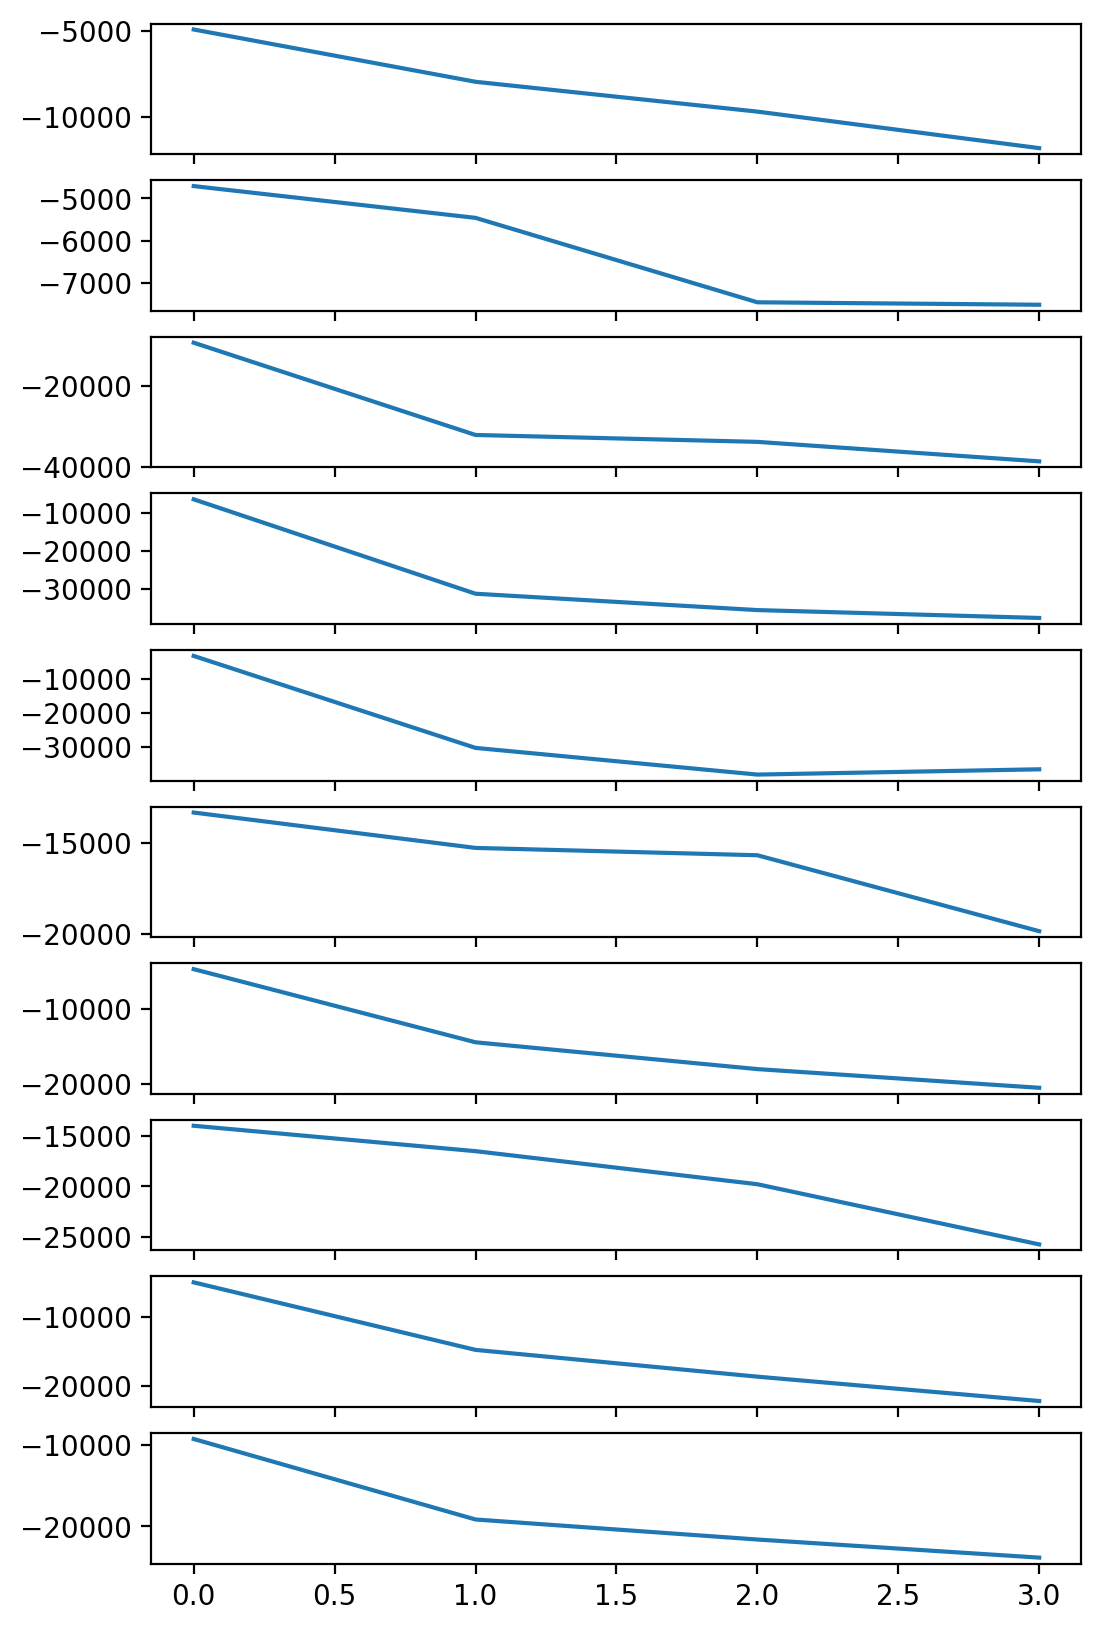

In [221]:
# 3. Fit a 3rd level GMM with the bic scores
third_level_gmm = GaussianMixture(n_components=1, random_state=34)
third_level_gmm.fit(transformed_scores)
print(third_level_gmm.bic(transformed_scores))

# 3. Fit a 3rd level GMM with the bic scores
third_level_gmm = GaussianMixture(n_components=2, random_state=34)
third_level_gmm.fit(transformed_scores)
print(third_level_gmm.bic(transformed_scores))

# 3. Fit a 3rd level GMM with the bic scores
third_level_gmm = GaussianMixture(n_components=3, random_state=34)
third_level_gmm.fit(transformed_scores)
print(third_level_gmm.bic(transformed_scores))

# How many days to sample
n_sample = 10

samples, _ = third_level_gmm.sample(n_samples=n_sample)
print(np.isnan(samples).sum())

# fig, axes = plt.subplots(figsize=(6, 10), sharex=True, nrows=n_sample)
# for day in range(n_sample):
#     ax = axes[day]
#     ax.plot(samples[day])

samples = inv_boxcox(samples.flatten().reshape(-1, 1), lambda_param)
samples = score_scaler.inverse_transform(samples).reshape((-1, n_model_types))

fig, axes = plt.subplots(figsize=(6, 10), sharex=True, nrows=n_sample)
for day in range(n_sample):
    ax = axes[day]
    ax.plot(samples[day])

In [241]:
# Softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))  # subtract max(x) for numerical stability
    return e_x / e_x.sum(axis=0)


In [249]:
deriv_cum_steps = np.zeros((n_sample, n_timestep))

for day in range(n_sample):
    
    # Choose with type of model to use ---------------------------
    
    # Draw a model type according to the goodness of fit 
    smp = samples[day]
    norm_score = (smp-smp.mean())/smp.std()
    p_according_to_gof = softmax(norm_score)
    
    model_idx = np.random.choice(n_model_types, p=p_according_to_gof)
    print(f"Day {day} is generated with model {model_idx+1}")

    # Draw the parameters of the 3rd level model using the 2nd level---------------------------
    second_level_gmm[model_idx].random_state = day
    samples_2nd, _ = second_level_gmm[model_idx].sample(n_samples=1)
    smp_2nd = samples_2nd[0]
    
    n_comp = list(n_components_range)[model_idx]
    
    transformed_means = smp_2nd[:n_components_range[model_idx]]
    transformed_vars = smp_2nd[n_components_range[model_idx]:2*n_components_range[model_idx]]
    if n_comp == 1:
        transformed_n = smp_2nd[2*n_components_range[model_idx]]
        transformed_weights = np.empty(0)
    else:
        transformed_weights = smp_2nd[2*n_components_range[model_idx]:3*n_components_range[model_idx]]
        transformed_n = smp_2nd[3*n_components_range[model_idx]]
        
    means = sigmoid(transformed_means)
    variances = np.expm1(transformed_vars)
    if n_comp == 1:
        weights = np.array([1])
    else:
        weights = softmax(transformed_weights)  # We want it to sum to 1
    n = int(np.expm1(transformed_n) * max_n)
    
    gmm = GaussianMixture(n_components=n_comp)
    gmm.means_ = means.reshape(-1, 1)
    gmm.covariances_ = variances.reshape(-1, 1, 1)
    gmm.weights_ = weights
    
    samples_1st, _ = gmm.sample(n_samples=n) 
    
    step_events_day = np.sort(samples_1st.flatten())
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
    deriv_cum_steps[day] = deriv_cum_steps_day 

Day 0 is generated with model 1
Day 1 is generated with model 4
Day 2 is generated with model 1
Day 3 is generated with model 2
Day 4 is generated with model 3
Day 5 is generated with model 4
Day 6 is generated with model 1
Day 7 is generated with model 1
Day 8 is generated with model 1
Day 9 is generated with model 1


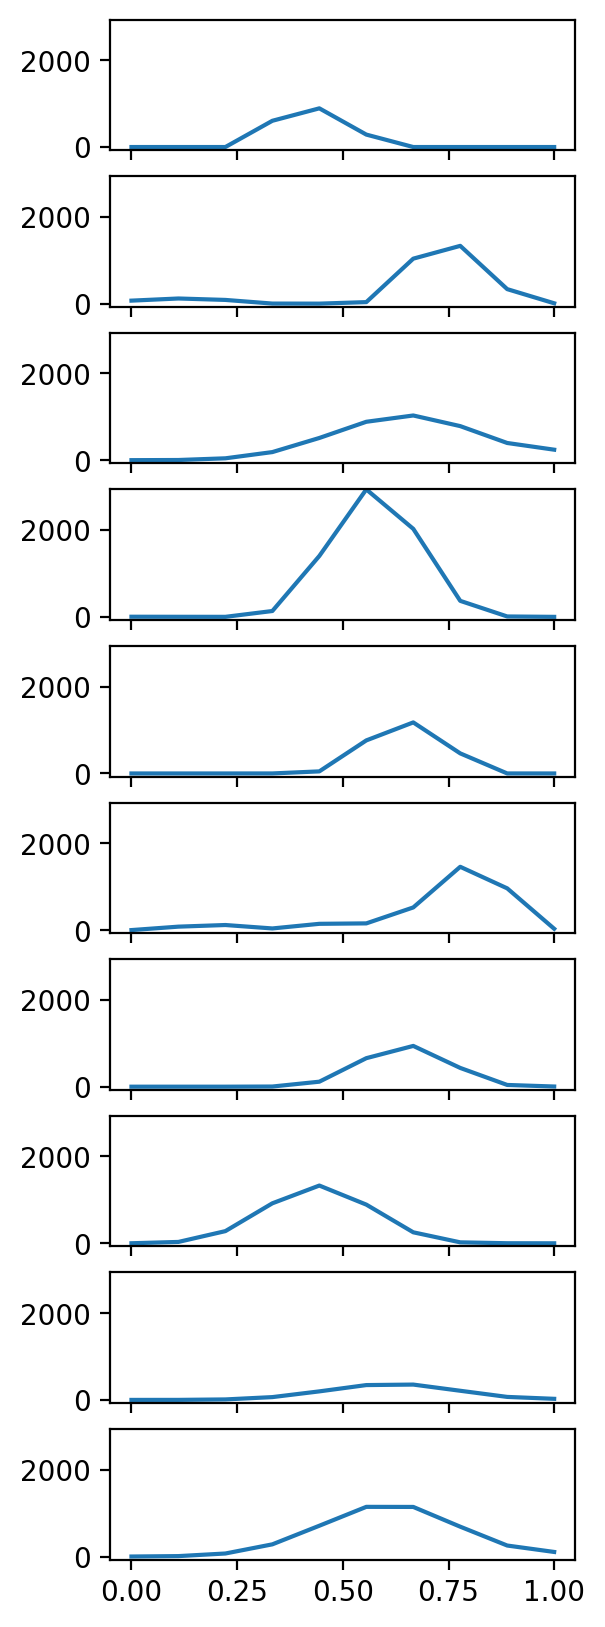

In [250]:
fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [31]:
# for model, n_components in enumerate(n_components_range):
#     gmm = GaussianMixture(n_components=1)
#     gmm.fit(param[model])
    # print("Means:", gmm.means_)
    # print("Covariances:", gmm.covariances_)
    # n_samples = 5
    # samples, _ = gmm.sample(n_samples)
    # n_timestep = 10
    # timestep = np.linspace(0, 1, n_timestep)
    # X_train = []
    # y_train = []
    # deriv_cum_steps = np.zeros((n_days, timestep.size))
    # for idx_day in range(n_days):
    #     samples, _ = gmm.sample(1)
    #     smp = samples[0]
    #     mu = smp[0]
    #     sigma = np.exp(smp[1])
    #     n = smp[2] * max_n
# 
# n_sample = 5
# 
# for idx_day in range(n_sample):
#     
#     # Choose with type of model to use
#     
#     draws = np.random.normal(mu, sigma, size=int(n))
# 
#     step_events_day = sigmoid(draws)
# 
#     cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
#     deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
#     deriv_cum_steps[idx_day] = deriv_cum_steps_day
#     # print(np.sum(deriv_cum_steps_day))
#     X_train.append(list(timestep))
#     y_train.append(list(deriv_cum_steps_day))
# 
# fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
# for ax, activity in zip(axes, deriv_cum_steps):
#     ax.plot(timestep, activity, color="C0")
#     ax.set_ylim(-70, np.max(deriv_cum_steps))
#     ax.grid(False)
# gmm = GaussianMixture(n_components=1)
# gmm.fit(param)
# print("Means:", gmm.means_)
# print("Covariances:", gmm.covariances_)
# n_samples = 5
# samples, _ = gmm.sample(n_samples)
# n_timestep = 10
# timestep = np.linspace(0, 1, n_timestep)
# X_train = []
# y_train = []
# deriv_cum_steps = np.zeros((n_days, timestep.size))
# for idx_day in range(n_days):
#     samples, _ = gmm.sample(1)
#     smp = samples[0]
#     mu = smp[0]
#     sigma = np.exp(smp[1])
#     n = smp[2] * max_n
# 
#     draws = np.random.normal(mu, sigma, size=int(n))
# 
#     step_events_day = sigmoid(draws)
# 
#     cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
#     deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
#     deriv_cum_steps[idx_day] = deriv_cum_steps_day
#     # print(np.sum(deriv_cum_steps_day))
#     X_train.append(list(timestep))
#     y_train.append(list(deriv_cum_steps_day))
# 
# fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
# for ax, activity in zip(axes, deriv_cum_steps):
#     ax.plot(timestep, activity, color="C0")
#     ax.set_ylim(-70, np.max(deriv_cum_steps))
#     ax.grid(False)